## 1. Import Library

Import seluruh library yang diperlukan. Library-library ini mencakup framework tensorflow untuk deep learning, tools preprocessing data dan augmentasi gambar, serta berbagai library untuk visualisasi dan evaluasi performa model. 

Jika belum menginstall library yang diperlukan, run: pip install ipykernel -r lib_requirement.txt
lalu install di venv dengan py -m ipykernel install --name=<nama_venv>

In [20]:
# library untuk manipulasi data dan sistem operasi
import os
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
from collections import Counter

# library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# library untuk image processing
from PIL import Image
import cv2

# library tensorflow dan keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

# library untuk evaluasi model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# konfigurasi visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"tensorflow version: {tf.__version__}")
print(f"gpu available: {tf.config.list_physical_devices('GPU')}")

tensorflow version: 2.20.0
gpu available: []


## 2. Data Collecting

Dataset diambil dari kumpulan dataset uang rupiah kertas dan koin dengan karakteristik yang mirip.

Analisis struktur dataset untuk memahami karakteristik data yang tersedia. Analisis mencakup perhitungan jumlah gambar per kelas, identifikasi ketidakseimbangan distribusi data, dan pemeriksaan properti gambar seperti dimensi dan format file.

In [21]:
# definisi path dataset
base_dir = Path(r'c:\Users\Farre\projects\rupiah-classification-model\data')
train_dir = base_dir / 'train'
valid_dir = base_dir / 'valid'
test_dir = base_dir / 'test'

# nama kelas nominal rupiah
class_names = sorted([
    'koin_100', 'koin_200', 'koin_500', 'koin_1000',
    'kertas_1000', 'kertas_2000', 'kertas_5000', 'kertas_10000',
    'kertas_20000', 'kertas_50000', 'kertas_100000'
])

print("struktur dataset:")
print(f"direktori base: {base_dir}")
print(f"direktori training: {train_dir}")
print(f"direktori validasi: {valid_dir}")
print(f"direktori testing: {test_dir}")
print(f"\njumlah kelas: {len(class_names)}")
print(f"daftar kelas: {class_names}")

struktur dataset:
direktori base: c:\Users\Farre\projects\rupiah-classification-model\data
direktori training: c:\Users\Farre\projects\rupiah-classification-model\data\train
direktori validasi: c:\Users\Farre\projects\rupiah-classification-model\data\valid
direktori testing: c:\Users\Farre\projects\rupiah-classification-model\data\test

jumlah kelas: 11
daftar kelas: ['kertas_1000', 'kertas_10000', 'kertas_100000', 'kertas_2000', 'kertas_20000', 'kertas_5000', 'kertas_50000', 'koin_100', 'koin_1000', 'koin_200', 'koin_500']


In [22]:
# fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(directory):
    """
    menghitung jumlah file gambar di setiap folder kelas
    
    args:
        directory: path ke direktori yang berisi folder kelas
    
    returns:
        dictionary dengan nama kelas sebagai key dan jumlah gambar sebagai value
    """
    counts = {}
    for class_name in class_names:
        class_path = directory / class_name
        if class_path.exists():
            counts[class_name] = len(list(class_path.glob('*')))
        else:
            counts[class_name] = 0
    return counts

# hitung jumlah gambar di setiap split
train_counts = count_images_per_class(train_dir)
valid_counts = count_images_per_class(valid_dir)
test_counts = count_images_per_class(test_dir)

# buat dataframe untuk analisis
df_counts = pd.DataFrame({
    'train': train_counts,
    'valid': valid_counts,
    'test': test_counts
})

df_counts['total'] = df_counts.sum(axis=1)
df_counts['train_pct'] = (df_counts['train'] / df_counts['total'] * 100).round(2)

print("\njumlah gambar per kelas:")
print(df_counts)
print(f"\ntotal gambar:")
print(f"training: {df_counts['train'].sum()}")
print(f"validasi: {df_counts['valid'].sum()}")
print(f"testing: {df_counts['test'].sum()}")
print(f"total keseluruhan: {df_counts['total'].sum()}")


jumlah gambar per kelas:
               train  valid  test  total  train_pct
kertas_1000      353    377   271   1001      35.26
kertas_10000     378    359   263   1000      37.80
kertas_100000    349    382   269   1000      34.90
kertas_2000      351    393   256   1000      35.10
kertas_20000     369    371   259    999      36.94
kertas_5000      357    380   263   1000      35.70
kertas_50000     382    354   264   1000      38.20
koin_100          44     40    18    102      43.14
koin_1000        364    367   269   1000      36.40
koin_200          66     53    35    154      42.86
koin_500         516    482   351   1349      38.25

total gambar:
training: 3529
validasi: 3558
testing: 2518
total keseluruhan: 9605


In [23]:
# analisis ketidakseimbangan dataset
train_mean = df_counts['train'].mean()
train_std = df_counts['train'].std()

print(f"\nstatistik distribusi data training:")
print(f"rata-rata gambar per kelas: {train_mean:.2f}")
print(f"standar deviasi: {train_std:.2f}")
print(f"minimum: {df_counts['train'].min()}")
print(f"maksimum: {df_counts['train'].max()}")

# identifikasi kelas yang tidak seimbang (di bawah 70% rata-rata)
threshold = train_mean * 0.7
imbalanced_classes = df_counts[df_counts['train'] < threshold]

print(f"\nkelas dengan data tidak seimbang (< {threshold:.0f} gambar):")
if len(imbalanced_classes) > 0:
    for idx, row in imbalanced_classes.iterrows():
        deficit = threshold - row['train']
        print(f"  {idx}: {row['train']} gambar (kurang {deficit:.0f} dari threshold)")
else:
    print("  tidak ada kelas yang sangat tidak seimbang")


statistik distribusi data training:
rata-rata gambar per kelas: 320.82
standar deviasi: 139.61
minimum: 44
maksimum: 516

kelas dengan data tidak seimbang (< 225 gambar):
  koin_100: 44.0 gambar (kurang 181 dari threshold)
  koin_200: 66.0 gambar (kurang 159 dari threshold)


In [24]:
# analisis properti gambar (ukuran, format, dll)
def analyze_image_properties(directory, sample_size=50):
    """
    menganalisis properti gambar seperti dimensi, format, dan ukuran file
    
    args:
        directory: path ke direktori dataset
        sample_size: jumlah gambar yang akan dianalisis per kelas
    
    returns:
        dataframe berisi statistik properti gambar
    """
    properties = []
    
    for class_name in class_names:
        class_path = directory / class_name
        if not class_path.exists():
            continue
            
        images = list(class_path.glob('*'))[:sample_size]
        
        for img_path in images:
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    properties.append({
                        'class': class_name,
                        'width': width,
                        'height': height,
                        'aspect_ratio': width / height,
                        'format': img.format,
                        'mode': img.mode,
                        'size_kb': os.path.getsize(img_path) / 1024
                    })
            except Exception as e:
                print(f"error membaca {img_path}: {e}")
    
    return pd.DataFrame(properties)

# analisis properti gambar dari training set
print("\nmenganalisis properti gambar dari training set...")
df_properties = analyze_image_properties(train_dir, sample_size=50)

print(f"\nstatistik dimensi gambar:")
print(df_properties[['width', 'height', 'aspect_ratio']].describe())

print(f"\nformat gambar:")
print(df_properties['format'].value_counts())

print(f"\nmode warna:")
print(df_properties['mode'].value_counts())


menganalisis properti gambar dari training set...

statistik dimensi gambar:
        width  height  aspect_ratio
count   544.0   544.0  5.440000e+02
mean   1280.0   720.0  1.777778e+00
std       0.0     0.0  4.444979e-16
min    1280.0   720.0  1.777778e+00
25%    1280.0   720.0  1.777778e+00
50%    1280.0   720.0  1.777778e+00
75%    1280.0   720.0  1.777778e+00
max    1280.0   720.0  1.777778e+00

format gambar:
format
JPEG    544
Name: count, dtype: int64

mode warna:
mode
RGB    544
Name: count, dtype: int64

statistik dimensi gambar:
        width  height  aspect_ratio
count   544.0   544.0  5.440000e+02
mean   1280.0   720.0  1.777778e+00
std       0.0     0.0  4.444979e-16
min    1280.0   720.0  1.777778e+00
25%    1280.0   720.0  1.777778e+00
50%    1280.0   720.0  1.777778e+00
75%    1280.0   720.0  1.777778e+00
max    1280.0   720.0  1.777778e+00

format gambar:
format
JPEG    544
Name: count, dtype: int64

mode warna:
mode
RGB    544
Name: count, dtype: int64


## 3. Data Analisis & Visualisasi

Visualisasi untuk memahami distribusi dan karakteristik dataset secara mendalam. Pada bagian ini akan dibuat berbagai plot untuk menganalisis keseimbangan data, melihat sampel gambar dari setiap kelas, dan mengidentifikasi potensi masalah dalam dataset.

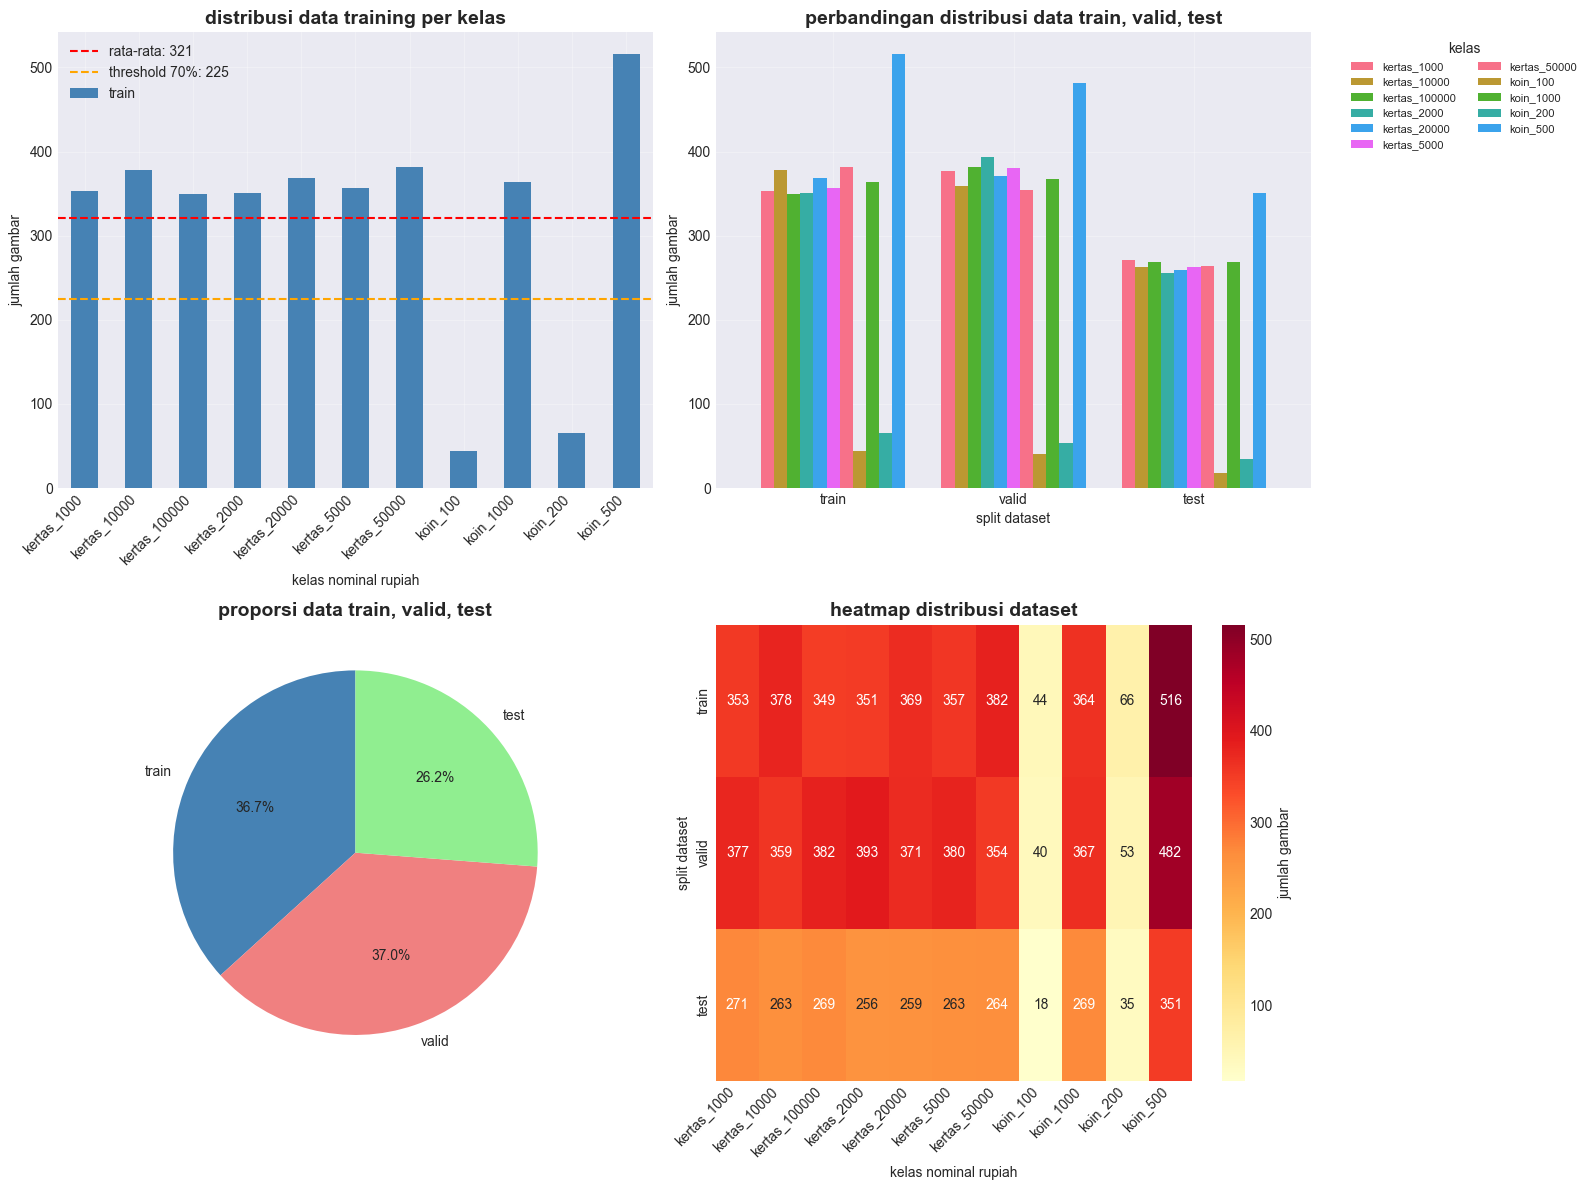

In [25]:
# visualisasi distribusi dataset
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1: distribusi data training per kelas
ax1 = axes[0, 0]
df_counts['train'].plot(kind='bar', ax=ax1, color='steelblue')
ax1.axhline(y=train_mean, color='r', linestyle='--', label=f'rata-rata: {train_mean:.0f}')
ax1.axhline(y=threshold, color='orange', linestyle='--', label=f'threshold 70%: {threshold:.0f}')
ax1.set_title('distribusi data training per kelas', fontsize=14, fontweight='bold')
ax1.set_xlabel('kelas nominal rupiah')
ax1.set_ylabel('jumlah gambar')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# plot 2: perbandingan train, valid, test
ax2 = axes[0, 1]
df_plot = df_counts[['train', 'valid', 'test']].T
df_plot.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_title('perbandingan distribusi data train, valid, test', fontsize=14, fontweight='bold')
ax2.set_xlabel('split dataset')
ax2.set_ylabel('jumlah gambar')
ax2.legend(title='kelas', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2, fontsize=8)
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=0)

# plot 3: proporsi tiap split
ax3 = axes[1, 0]
total_per_split = [df_counts['train'].sum(), df_counts['valid'].sum(), df_counts['test'].sum()]
colors = ['steelblue', 'lightcoral', 'lightgreen']
ax3.pie(total_per_split, labels=['train', 'valid', 'test'], autopct='%1.1f%%', 
        colors=colors, startangle=90)
ax3.set_title('proporsi data train, valid, test', fontsize=14, fontweight='bold')

# plot 4: heatmap distribusi
ax4 = axes[1, 1]
heatmap_data = df_counts[['train', 'valid', 'test']].T
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'jumlah gambar'})
ax4.set_title('heatmap distribusi dataset', fontsize=14, fontweight='bold')
ax4.set_xlabel('kelas nominal rupiah')
ax4.set_ylabel('split dataset')
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

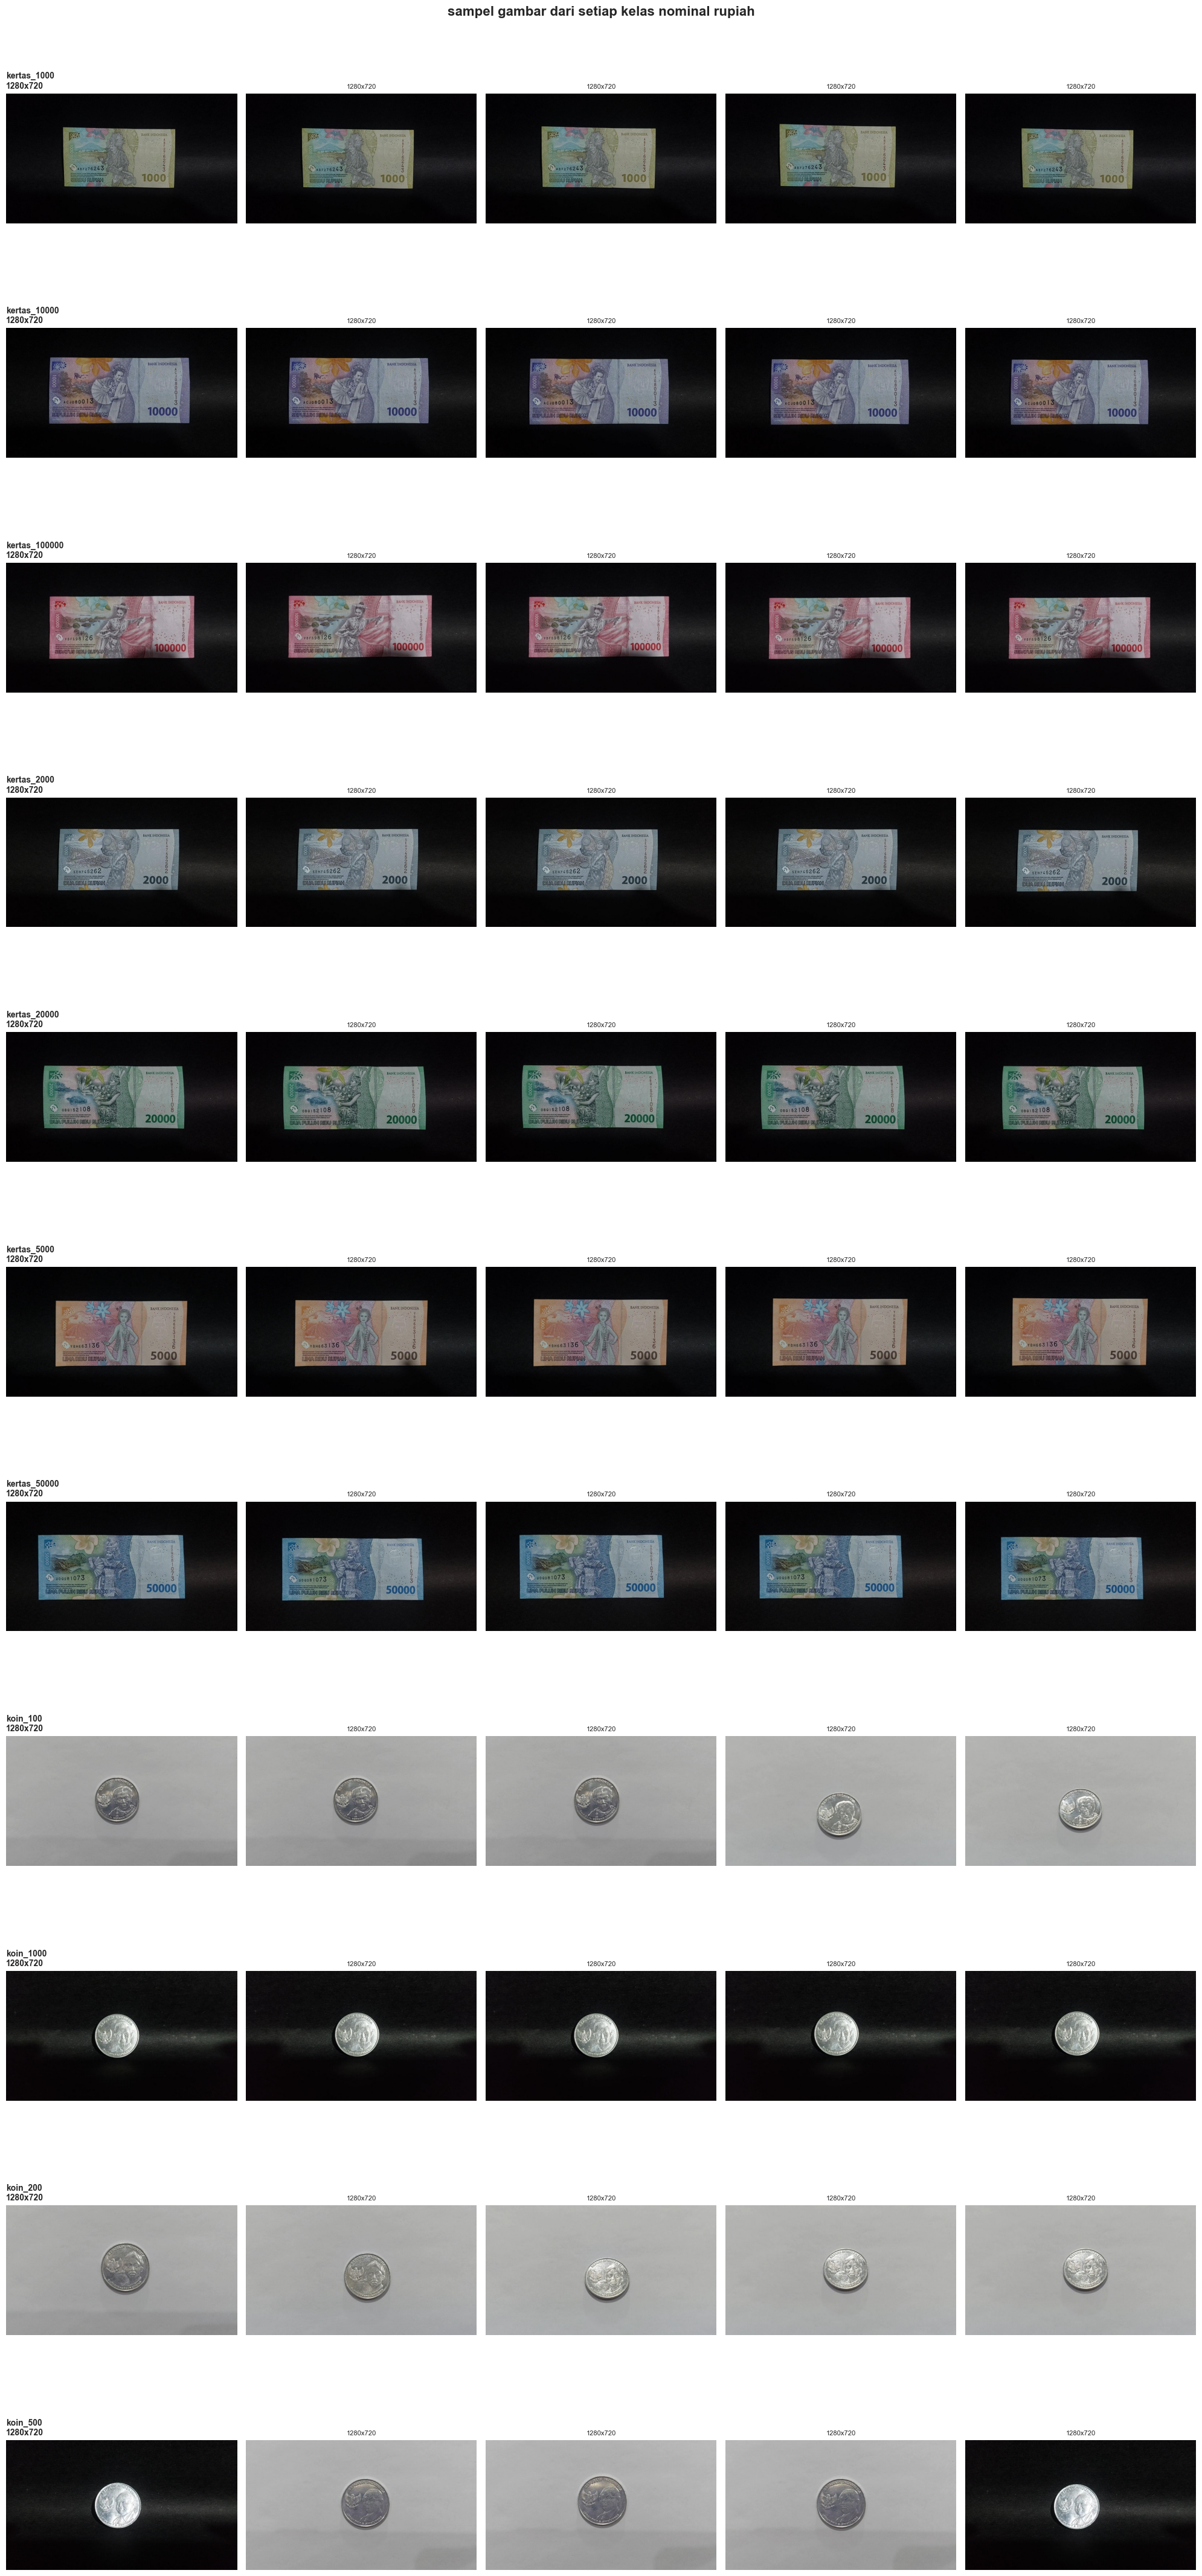

In [26]:
# visualisasi sampel gambar dari setiap kelas
fig, axes = plt.subplots(11, 5, figsize=(20, 44))

for idx, class_name in enumerate(class_names):
    class_path = train_dir / class_name
    images = list(class_path.glob('*'))[:5]
    
    for col, img_path in enumerate(images):
        ax = axes[idx, col]
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')
        if col == 0:
            ax.set_title(f'{class_name}\n{img.size[0]}x{img.size[1]}', 
                        fontsize=10, fontweight='bold', loc='left')
        else:
            ax.set_title(f'{img.size[0]}x{img.size[1]}', fontsize=8)

plt.suptitle('sampel gambar dari setiap kelas nominal rupiah', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [27]:
# metadata lengkap dataset
# pisahkan kelas berdasarkan jenis uang
koin_classes = [class_name for class_name in class_names if 'koin' in class_name]
kertas_classes = [class_name for class_name in class_names if 'kertas' in class_name]

print("\nringkasan metadata dataset:")
print(f"\ntipe jenis uang:")
print(f"  koin: {len(koin_classes)} kelas")
print(f"    {koin_classes}")
print(f"  kertas: {len(kertas_classes)} kelas")
print(f"    {kertas_classes}")

overall_stats = pd.DataFrame({
    'metrik': ['total gambar', 'jumlah kelas', 'rata-rata per kelas', 'std deviasi', 
               'min per kelas', 'max per kelas', 'median per kelas'],
    'train': [df_counts['train'].sum(), len(class_names), df_counts['train'].mean(),
              df_counts['train'].std(), df_counts['train'].min(), df_counts['train'].max(),
              df_counts['train'].median()],
    'valid': [df_counts['valid'].sum(), len(class_names), df_counts['valid'].mean(),
              df_counts['valid'].std(), df_counts['valid'].min(), df_counts['valid'].max(),
              df_counts['valid'].median()],
    'test': [df_counts['test'].sum(), len(class_names), df_counts['test'].mean(),
             df_counts['test'].std(), df_counts['test'].min(), df_counts['test'].max(),
             df_counts['test'].median()]
})

print("\nstatistik keseluruhan:")
print(overall_stats.to_string(index=False))


ringkasan metadata dataset:

tipe jenis uang:
  koin: 4 kelas
    ['koin_100', 'koin_1000', 'koin_200', 'koin_500']
  kertas: 7 kelas
    ['kertas_1000', 'kertas_10000', 'kertas_100000', 'kertas_2000', 'kertas_20000', 'kertas_5000', 'kertas_50000']

statistik keseluruhan:
             metrik       train       valid        test
       total gambar 3529.000000 3558.000000 2518.000000
       jumlah kelas   11.000000   11.000000   11.000000
rata-rata per kelas  320.818182  323.454545  228.909091
        std deviasi  139.608609  141.177451  103.523383
      min per kelas   44.000000   40.000000   18.000000
      max per kelas  516.000000  482.000000  351.000000
   median per kelas  357.000000  371.000000  263.000000


## 4. Data Preprocessing & Augmentation

Tahap Data Preprocessing dan Data Augmentation akan membantu membuat dataset lebih siap digunakan dan robust dengan mengatasi ketidakseimbangan dataset sehingga meningkatkan kemampuan generalisasi model. Kelas dengan sampel terbatas akan mendapatkan augmentasi yang lebih intensif untuk menyeimbangkan distribusi data training.

In [28]:
# konfigurasi preprocessing
IMG_SIZE = (224, 224)  # ukuran input standar untuk cnn
BATCH_SIZE = 32
TARGET_SAMPLES = 500  # target jumlah gambar per kelas setelah augmentasi

print("konfigurasi preprocessing:")
print(f"ukuran gambar input: {IMG_SIZE}")
print(f"batch size: {BATCH_SIZE}")
print(f"target sampel per kelas: {TARGET_SAMPLES}")

konfigurasi preprocessing:
ukuran gambar input: (224, 224)
batch size: 32
target sampel per kelas: 500


In [29]:
# data augmentation untuk training dengan teknik yang lebih agresif
# augmentasi ini membantu model untuk lebih robust terhadap variasi gambar
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalisasi pixel value ke range 0-1
    rotation_range=20,  # rotasi random hingga 20 derajat
    width_shift_range=0.2,  # shift horizontal hingga 20%
    height_shift_range=0.2,  # shift vertikal hingga 20%
    shear_range=0.2,  # shear transformation
    zoom_range=0.2,  # zoom in/out random
    horizontal_flip=True,  # flip horizontal random
    brightness_range=[0.8, 1.2],  # variasi brightness
    fill_mode='nearest'  # metode untuk mengisi pixel yang hilang
)

# untuk validasi dan testing, hanya normalisasi tanpa augmentasi
# ini penting untuk evaluasi yang konsisten dan fair
valid_test_datagen = ImageDataGenerator(
    rescale=1./255
)

print("data augmentation configuration:")
print("training: rotasi, shift, shear, zoom, flip, brightness adjustment")
print("validation & test: hanya normalisasi")

data augmentation configuration:
training: rotasi, shift, shear, zoom, flip, brightness adjustment
validation & test: hanya normalisasi


In [30]:
# buat data generator untuk training, validation, dan testing
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # multi-class classification
    shuffle=True,  # shuffle data setiap epoch
    seed=42
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # tidak shuffle untuk validasi
    seed=42
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,  # tidak shuffle untuk testing
    seed=42
)

print(f"\ndata generator berhasil dibuat:")
print(f"training samples: {train_generator.samples}")
print(f"validation samples: {valid_generator.samples}")
print(f"testing samples: {test_generator.samples}")
print(f"\nclass indices: {train_generator.class_indices}")

Found 3529 images belonging to 11 classes.
Found 3558 images belonging to 11 classes.
Found 3558 images belonging to 11 classes.
Found 2518 images belonging to 11 classes.
Found 2518 images belonging to 11 classes.

data generator berhasil dibuat:
training samples: 3529
validation samples: 3558
testing samples: 2518

class indices: {'kertas_1000': 0, 'kertas_10000': 1, 'kertas_100000': 2, 'kertas_2000': 3, 'kertas_20000': 4, 'kertas_5000': 5, 'kertas_50000': 6, 'koin_100': 7, 'koin_1000': 8, 'koin_200': 9, 'koin_500': 10}

data generator berhasil dibuat:
training samples: 3529
validation samples: 3558
testing samples: 2518

class indices: {'kertas_1000': 0, 'kertas_10000': 1, 'kertas_100000': 2, 'kertas_2000': 3, 'kertas_20000': 4, 'kertas_5000': 5, 'kertas_50000': 6, 'koin_100': 7, 'koin_1000': 8, 'koin_200': 9, 'koin_500': 10}


In [31]:
# hitung class weights untuk menangani ketidakseimbangan dataset
# class weights memberikan bobot lebih tinggi pada kelas minority
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))

print("\nclass weights untuk menangani imbalanced dataset:")
for idx, class_name in enumerate(class_names):
    weight = class_weights_dict[idx]
    count = train_counts[class_name]
    print(f"{class_name:15} | count: {count:3} | weight: {weight:.3f}")


class weights untuk menangani imbalanced dataset:
kertas_1000     | count: 353 | weight: 0.909
kertas_10000    | count: 378 | weight: 0.849
kertas_100000   | count: 349 | weight: 0.919
kertas_2000     | count: 351 | weight: 0.914
kertas_20000    | count: 369 | weight: 0.869
kertas_5000     | count: 357 | weight: 0.899
kertas_50000    | count: 382 | weight: 0.840
koin_100        | count:  44 | weight: 7.291
koin_1000       | count: 364 | weight: 0.881
koin_200        | count:  66 | weight: 4.861
koin_500        | count: 516 | weight: 0.622



visualisasi hasil data augmentation:


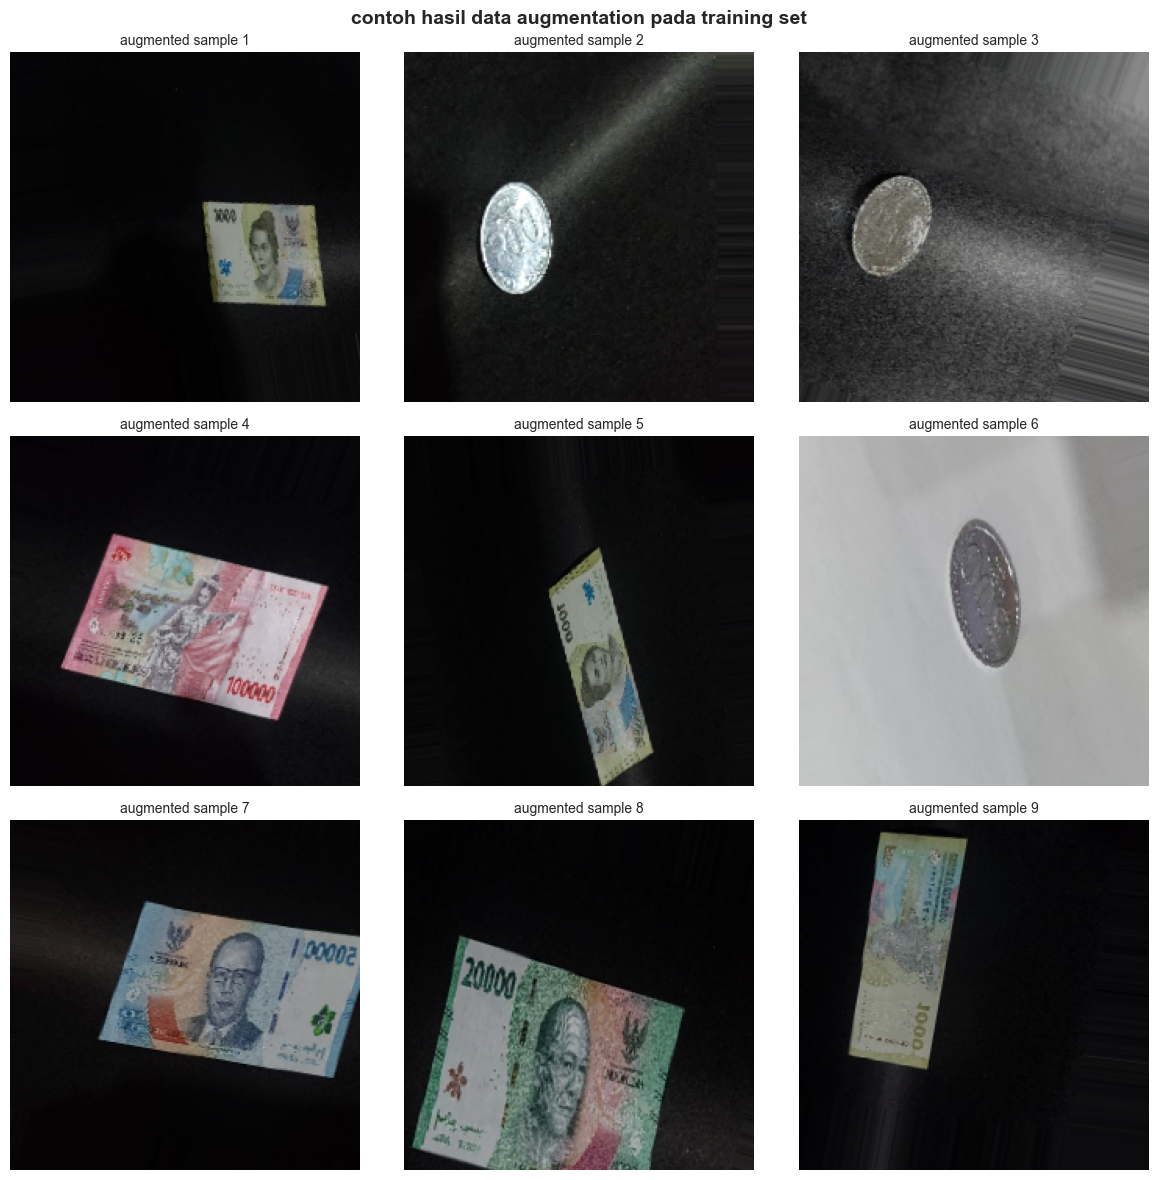

In [32]:
# visualisasi sample hasil augmentasi
print("\nvisualisasi hasil data augmentation:")

# ambil satu batch dari generator
sample_batch = next(train_generator)
sample_images = sample_batch[0][:9]  # ambil 9 gambar pertama

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for idx, img in enumerate(sample_images):
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'augmented sample {idx+1}', fontsize=10)

plt.suptitle('contoh hasil data augmentation pada training set', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# reset generator setelah visualisasi
train_generator.reset()

## 5. Data Modeling

Arsitektur model dirancang khusus dengan CNN untuk klasifikasi gambar uang rupiah. Model dibangun dari nol dengan lima blok konvolusi yang semakin dalam untuk ekstraksi fitur hierarkis, dilengkapi dengan batch normalization untuk stabilitas training dan dropout untuk mencegah overfitting/underfitting.

In [ ]:
# hyperparameter untuk training
LEARNING_RATE = 0.001
EPOCHS = 50  # akan dihentikan lebih awal jika tidak ada improvement

print("hyperparameter training:")
print(f"learning rate: {LEARNING_RATE}")
print(f"max epochs: {EPOCHS}")
print(f"optimizer: Adam")
print(f"loss function: categorical crossentropy")
print(f"metrics: accuracy, top-2 accuracy, precision, recall")

hyperparameter training:
learning rate: 0.001
max epochs: 50
optimizer: Adam
loss function: categorical crossentropy
metrics: accuracy, top-2 accuracy, precision, recall


In [34]:
# arsitektur model 
# 1. global average pooling untuk mengurangi parameter
# 2. l2 regularization pada dense layers
# 3. batch normalization setelah pooling
# 4. dropout bertahap

model = models.Sequential([
    # input layer
    layers.Input(shape=(224, 224, 3)),
    
    # convolutional block 1: fitur dasar (edge, texture)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_1'),
    layers.BatchNormalization(name='bn1_1'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1_2'),
    layers.BatchNormalization(name='bn1_2'),
    layers.MaxPooling2D((2, 2), name='pool1'),
    layers.Dropout(0.2, name='dropout1'),  # reduced dari 0.25
    
    # convolutional block 2: fitur lebih kompleks
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1'),
    layers.BatchNormalization(name='bn2_1'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2'),
    layers.BatchNormalization(name='bn2_2'),
    layers.MaxPooling2D((2, 2), name='pool2'),
    layers.Dropout(0.2, name='dropout2'),  # reduced dari 0.25
    
    # convolutional block 3: fitur abstrak tingkat menengah
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1'),
    layers.BatchNormalization(name='bn3_1'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2'),
    layers.BatchNormalization(name='bn3_2'),
    layers.MaxPooling2D((2, 2), name='pool3'),
    layers.Dropout(0.3, name='dropout3'),
    
    # convolutional block 4: fitur abstrak tingkat tinggi
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1'),
    layers.BatchNormalization(name='bn4_1'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_2'),
    layers.BatchNormalization(name='bn4_2'),
    layers.MaxPooling2D((2, 2), name='pool4'),
    layers.Dropout(0.3, name='dropout4'),
    
    # convolutional block 5: fitur paling abstrak dan spesifik
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_1'),
    layers.BatchNormalization(name='bn5_1'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv5_2'),
    layers.BatchNormalization(name='bn5_2'),
    layers.MaxPooling2D((2, 2), name='pool5'),
    layers.Dropout(0.4, name='dropout5'),
    
    # global average pooling
    layers.GlobalAveragePooling2D(name='global_avg_pool'),
    layers.BatchNormalization(name='bn_global'),
    
    # layering dengan l2 regularization
    layers.Dense(512, activation='relu', 
                kernel_regularizer=keras.regularizers.l2(0.001),
                name='fc1'),
    layers.BatchNormalization(name='bn_fc1'),
    layers.Dropout(0.5, name='dropout_fc1'),
    
    layers.Dense(256, activation='relu',
                kernel_regularizer=keras.regularizers.l2(0.001),
                name='fc2'),
    layers.BatchNormalization(name='bn_fc2'),
    layers.Dropout(0.3, name='dropout_fc2'),  # reduced dari 0.5
    
    # output layer: 11 kelas nominal rupiah
    layers.Dense(len(class_names), activation='softmax', name='output')
])

In [35]:
# compile model dengan optimizer, loss, dan metrics
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top2_accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# tampilkan summary arsitektur model
model.summary()

# hitung total parameter
total_params = model.count_params()
trainable_params = np.sum([tf.size(v).numpy() for v in model.trainable_weights])
non_trainable_params = np.sum([tf.size(v).numpy() for v in model.non_trainable_weights])

print(f"\ntotal parameters: {total_params:,}")
print(f"trainable parameters: {trainable_params:,}")
print(f"non-trainable parameters: {non_trainable_params:,}")

print("\nperbandingan arsitektur:")
print("  arsitektur lama: flatten + dense → banyak parameter → prone to overfitting")
print("  arsitektur baru: global avg pooling + dense → less parameter → better generalization")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2 (Conv2D)                │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_2 (BatchNormalization)      │ (None, 224, 224, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 112, 112, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 56, 56, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4_1 (BatchNormalization)      │ (None, 28, 28, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2 (Conv2D)                │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4_2 (BatchNormalization)      │ (None, 28, 28, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_1 (Conv2D)                │ (None, 14, 14, 512)    │     1,180,16

 Total params: 5,122,091 (19.54 MB)

 Trainable params: 5,115,563 (19.51 MB)

 Non-trainable params: 6,528 (25.50 KB)


total parameters: 5,122,091
trainable parameters: 5,115,563
non-trainable parameters: 6,528

perbandingan arsitektur:
  arsitektur lama: flatten + dense → banyak parameter → prone to overfitting
  arsitektur baru: global avg pooling + dense → less parameter → better generalization


In [36]:
# setup callbacks untuk optimalisasi training 

# direktori untuk menyimpan checkpoint dan logs
checkpoint_dir = Path('../checkpoints')
log_dir = Path('../logs')
checkpoint_dir.mkdir(exist_ok=True)
log_dir.mkdir(exist_ok=True)

# 1. model checkpoint: simpan model terbaik berdasarkan validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=str(checkpoint_dir / 'best_model.keras'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 2. early stopping: stop training jika tidak ada improvement
# patience=7
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

# 3. reduce learning rate: jika stuck di plateau, kurangi learning speed
# fine tuning
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=3,
    min_lr=1e-7,
    mode='min',
    verbose=1
)

# 4. tensorboard: logging untuk visualisasi training progress
tensorboard_callback = TensorBoard(
    log_dir=str(log_dir),
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch'
)

callbacks_list = [
    checkpoint_callback,
    early_stopping_callback,
    reduce_lr_callback,
    tensorboard_callback
]

In [37]:
# training model
# hitung steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = valid_generator.samples // BATCH_SIZE

print(f"steps per epoch: {steps_per_epoch}")
print(f"validation steps: {validation_steps}\n")

# mulai training dengan class weights untuk handle imbalanced data
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list,
    class_weight=class_weights_dict,
    verbose=1
)

print("\ntraining selesai")

steps per epoch: 110
validation steps: 111

Epoch 1/50
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3385 - loss: 3.0550 - precision: 0.4361 - recall: 0.2391 - top2_accuracy: 0.5238
Epoch 1: val_accuracy improved from None to 0.13373, saving model to ..\checkpoints\best_model.keras

Epoch 1: val_accuracy improved from None to 0.13373, saving model to ..\checkpoints\best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 859s 8s/step - accuracy: 0.5021 - loss: 2.5357 - precision: 0.6119 - recall: 0.4144 - top2_accuracy: 0.7149 - val_accuracy: 0.1337 - val_loss: 7.6512 - val_precision: 0.1387 - val_recall: 0.1326 - val_top2_accuracy: 0.2635 - learning_rate: 0.0010
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 859s 8s/step - accuracy: 0.5021 - loss: 2.5357 - precision: 0.6119 - recall: 0.4144 - top2_accuracy: 0.7149 - val_accuracy: 0.1337 - val_loss: 7.6512 - val_precision: 0.1387 - val_recall: 0.1326 - val_top2_accuracy: 0.2635 - learning_rate: 0.0010
Epoch 2/50
  1/110 ━━━━━━━━━━━━━━

c:\Users\Farre\projects\rupiah-classification-model\my_venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.13373
110/110 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6250 - loss: 1.5960 - precision: 0.6786 - recall: 0.5938 - top2_accuracy: 0.9688 - val_accuracy: 0.1323 - val_loss: 7.5914 - val_precision: 0.1353 - val_recall: 0.1273 - val_top2_accuracy: 0.2615 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.6250 - loss: 1.5960 - precision: 0.6786 - recall: 0.5938 - top2_accuracy: 0.9688 - val_accuracy: 0.1323 - val_loss: 7.5914 - val_precision: 0.1353 - val_recall: 0.1273 - val_top2_accuracy: 0.2615 - learning_rate: 0.0010
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7368 - loss: 1.7754 - precision: 0.7785 - recall: 0.6967 - top2_accuracy: 0.9047
Epoch 3: val_accuracy improved from 0.13373 to 0.22354, saving model to ..\checkpoints\best_model.keras

Epoch 3: val_accuracy improved from 0.13373 to 0.22354, saving model to ..\checkpoints\best_model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 8

## 6. Evaluasi Model

Evaluasi dilakukan untuk mengukur performa model pada data yang belum pernah dilihat sebelumnya. Metrik evaluasi mencakup accuracy, precision, recall, dan f1-score. Visualisasi confusion matrix akan membantu mengidentifikasi pola kesalahan prediksi antar kelas.

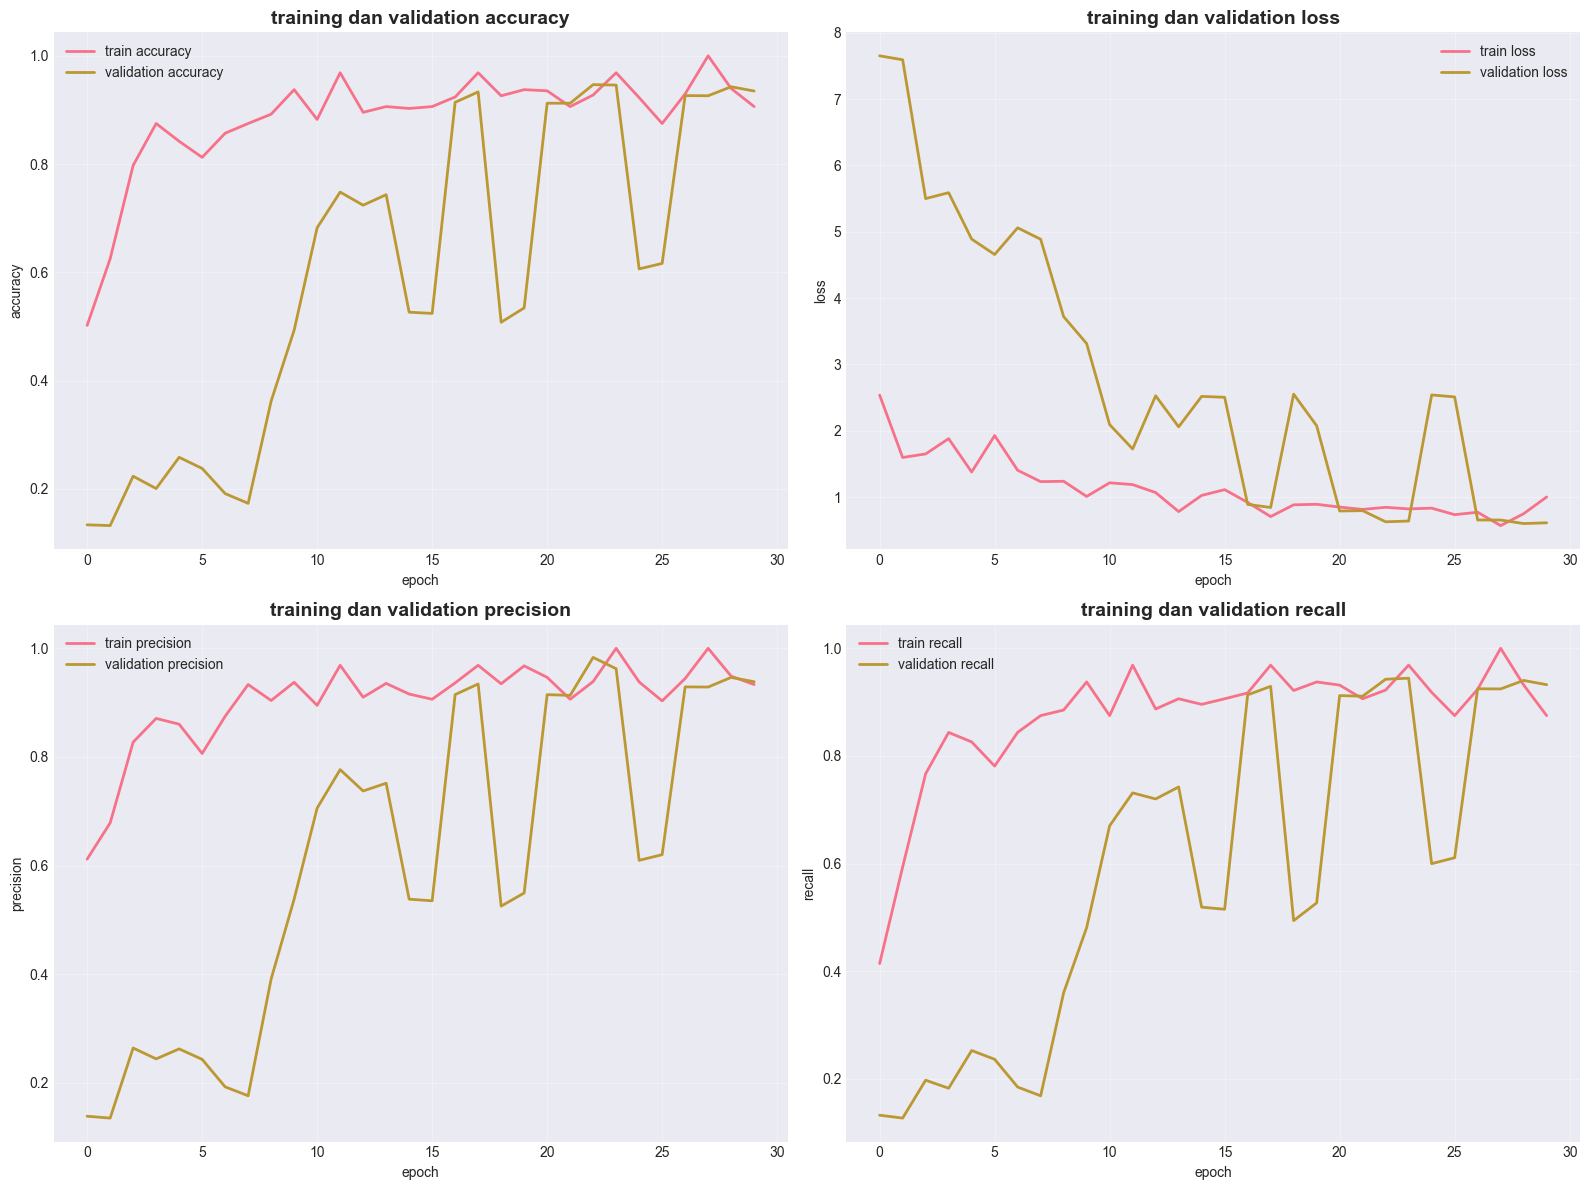

In [38]:
# visualisasi training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1: accuracy
ax1 = axes[0, 0]
ax1.plot(history.history['accuracy'], label='train accuracy', linewidth=2)
ax1.plot(history.history['val_accuracy'], label='validation accuracy', linewidth=2)
ax1.set_title('training dan validation accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# plot 2: loss
ax2 = axes[0, 1]
ax2.plot(history.history['loss'], label='train loss', linewidth=2)
ax2.plot(history.history['val_loss'], label='validation loss', linewidth=2)
ax2.set_title('training dan validation loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# plot 3: precision
ax3 = axes[1, 0]
ax3.plot(history.history['precision'], label='train precision', linewidth=2)
ax3.plot(history.history['val_precision'], label='validation precision', linewidth=2)
ax3.set_title('training dan validation precision', fontsize=14, fontweight='bold')
ax3.set_xlabel('epoch')
ax3.set_ylabel('precision')
ax3.legend()
ax3.grid(True, alpha=0.3)

# plot 4: recall
ax4 = axes[1, 1]
ax4.plot(history.history['recall'], label='train recall', linewidth=2)
ax4.plot(history.history['val_recall'], label='validation recall', linewidth=2)
ax4.set_title('training dan validation recall', fontsize=14, fontweight='bold')
ax4.set_xlabel('epoch')
ax4.set_ylabel('recall')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [39]:
# analisis overfitting/underfitting
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
acc_gap = final_train_acc - final_val_acc

print("\nanalisis overfitting/underfitting:")
print(f"final training accuracy: {final_train_acc:.4f}")
print(f"final validation accuracy: {final_val_acc:.4f}")
print(f"accuracy gap: {acc_gap:.4f}")

if acc_gap < 0.05:
    print("\nkesimpulan: model well-fitted")
    print("gap antara training dan validation accuracy sangat kecil, menunjukkan generalisasi yang baik")
elif acc_gap < 0.10:
    print("\nkesimpulan: model slight overfitting")
    print("gap antara training dan validation accuracy masih dalam batas wajar untuk model deep learning")
else:
    print("\nkesimpulan: model overfitting")
    print("perlu tambahan regularisasi atau data augmentation untuk meningkatkan generalisasi")


analisis overfitting/underfitting:
final training accuracy: 0.9062
final validation accuracy: 0.9350
accuracy gap: -0.0287

kesimpulan: model well-fitted
gap antara training dan validation accuracy sangat kecil, menunjukkan generalisasi yang baik


In [40]:
# evaluasi model pada test set
print("\nevaluasi model pada test set...")

test_loss, test_accuracy, test_top2_accuracy, test_precision, test_recall = model.evaluate(
    test_generator,
    steps=test_generator.samples // BATCH_SIZE,
    verbose=1
)

# hitung f1-score
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("\nhasil evaluasi pada test set:")
print(f"test loss: {test_loss:.4f}")
print(f"test accuracy: {test_accuracy:.4f}")
print(f"test top-2 accuracy: {test_top2_accuracy:.4f}")
print(f"test precision: {test_precision:.4f}")
print(f"test recall: {test_recall:.4f}")
print(f"test f1-score: {test_f1:.4f}")


evaluasi model pada test set...
78/78 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9519 - loss: 0.6190 - precision: 0.9845 - recall: 0.9443 - top2_accuracy: 0.9712

hasil evaluasi pada test set:
test loss: 0.6190
test accuracy: 0.9519
test top-2 accuracy: 0.9712
test precision: 0.9845
test recall: 0.9443
test f1-score: 0.9640
78/78 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9519 - loss: 0.6190 - precision: 0.9845 - recall: 0.9443 - top2_accuracy: 0.9712

hasil evaluasi pada test set:
test loss: 0.6190
test accuracy: 0.9519
test top-2 accuracy: 0.9712
test precision: 0.9845
test recall: 0.9443
test f1-score: 0.9640


In [41]:
# prediksi pada test set untuk confusion matrix dan classification report
print("\nmembuat prediksi pada test set...")

# reset generator untuk memastikan urutan yang konsisten
test_generator.reset()

# prediksi
y_pred_proba = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# ambil true labels
y_true = test_generator.classes[:len(y_pred)]

print(f"\njumlah prediksi: {len(y_pred)}")
print(f"jumlah true labels: {len(y_true)}")


membuat prediksi pada test set...
78/78 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step

jumlah prediksi: 2496
jumlah true labels: 2496

jumlah prediksi: 2496
jumlah true labels: 2496


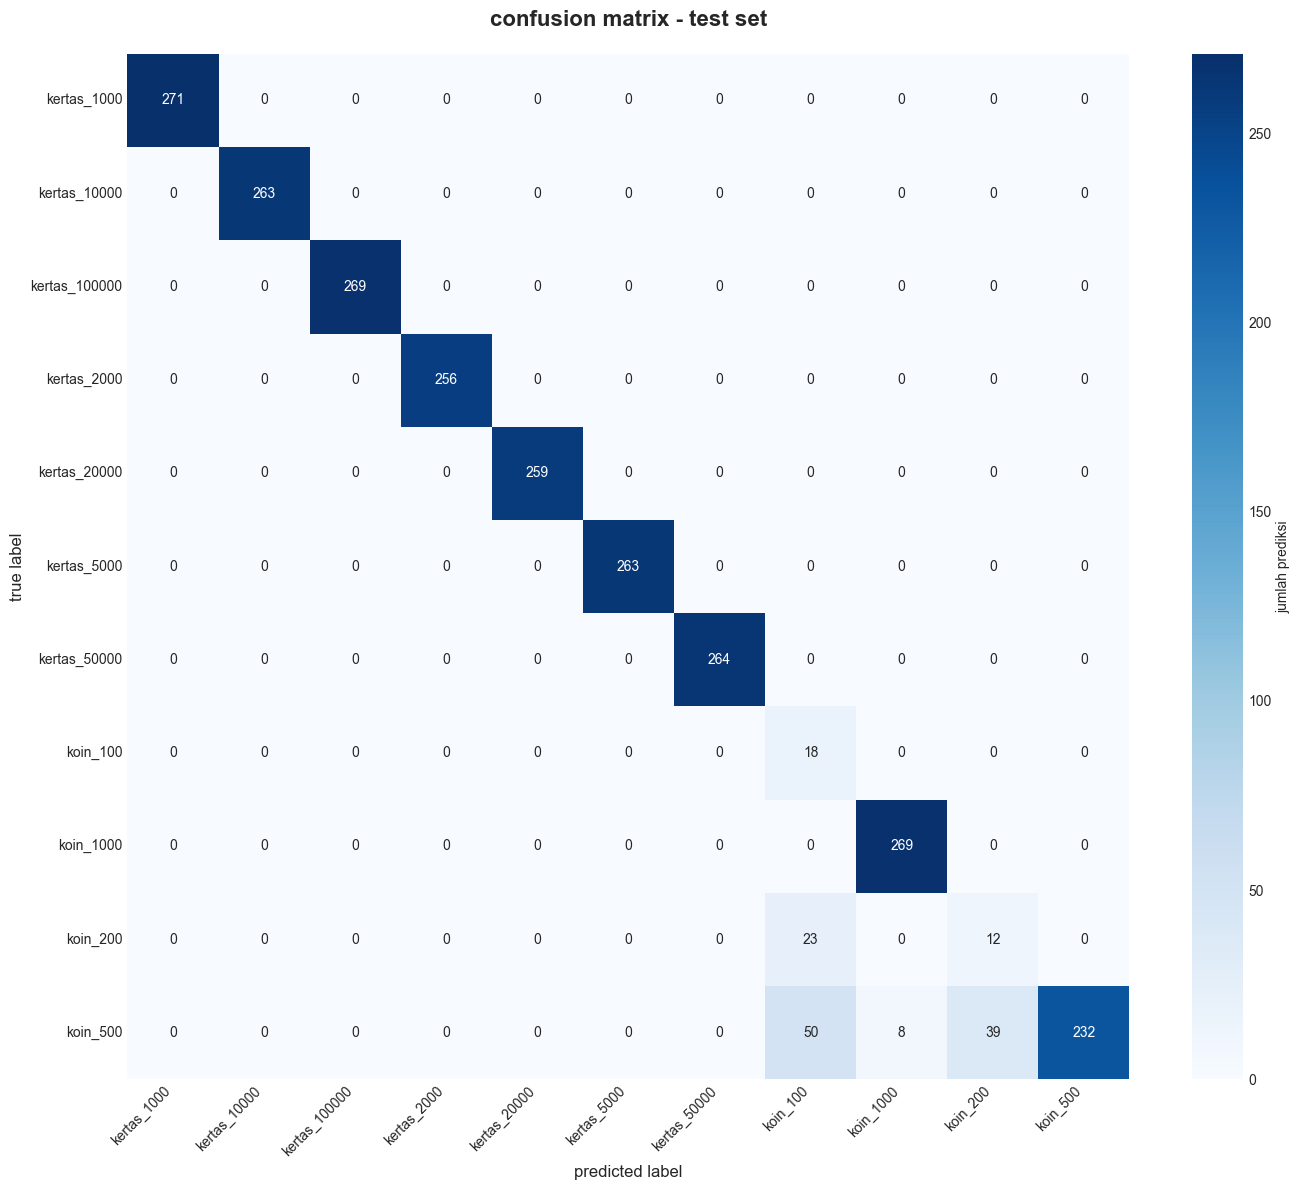

In [42]:
# confusion matrix
cm = confusion_matrix(y_true, y_pred)

# visualisasi confusion matrix
plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'jumlah prediksi'}
)
plt.title('confusion matrix - test set', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('predicted label', fontsize=12)
plt.ylabel('true label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

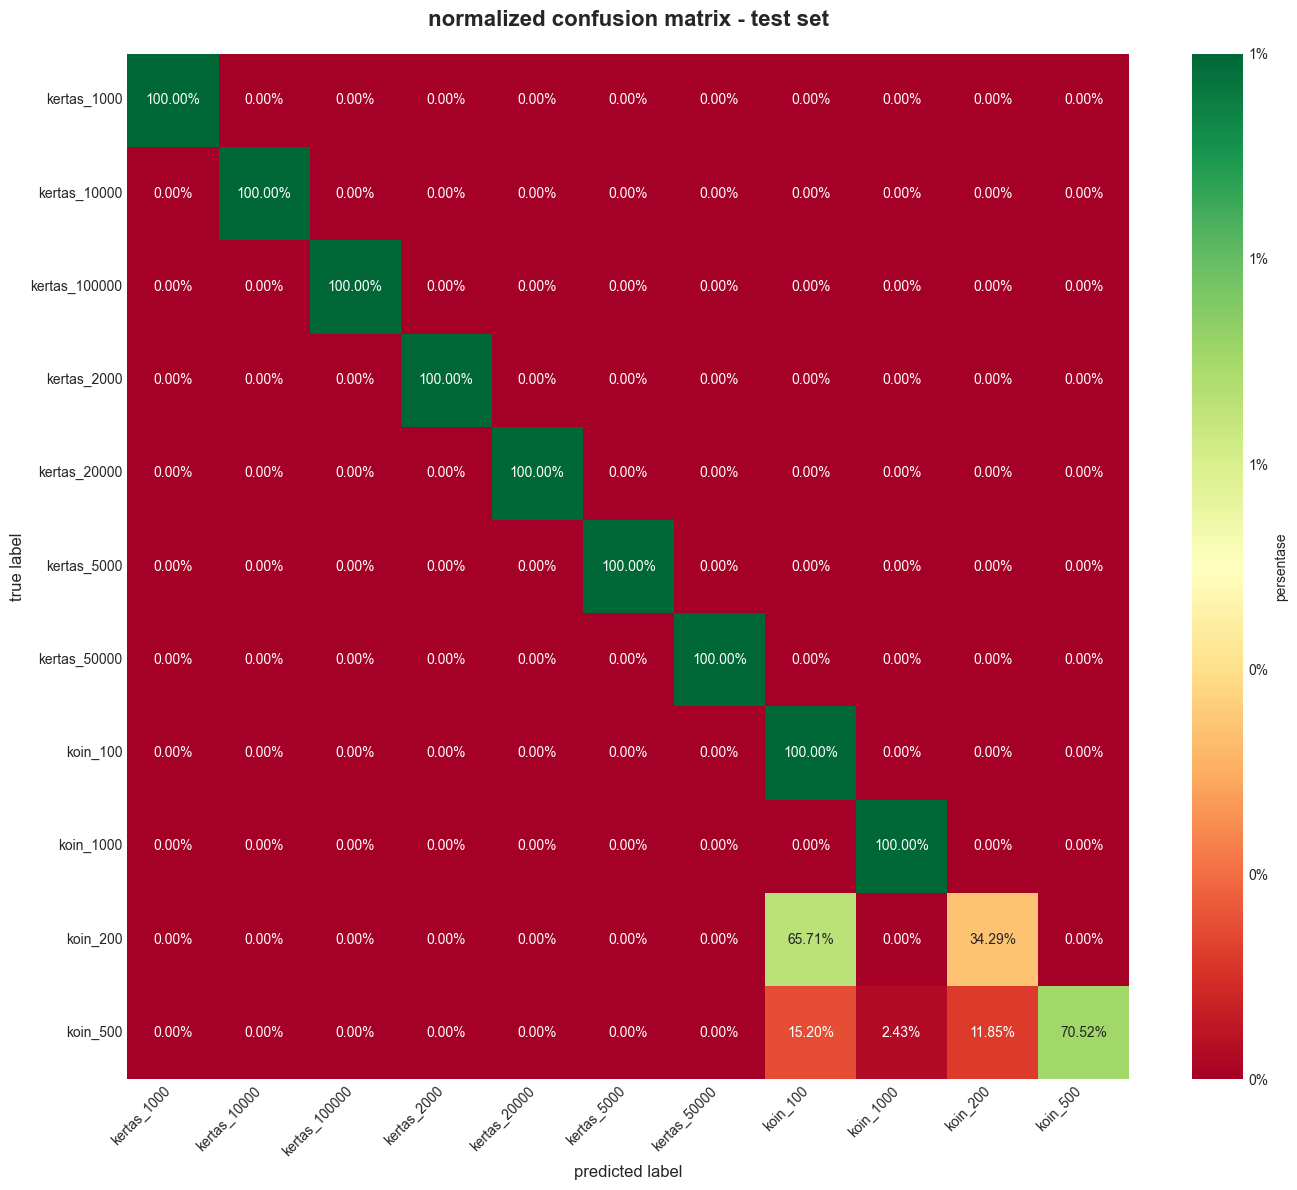

In [43]:
# normalized confusion matrix (persentase)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2%', 
    cmap='RdYlGn',
    xticklabels=class_names,
    yticklabels=class_names,
    cbar_kws={'label': 'persentase', 'format': '%.0f%%'},
    vmin=0,
    vmax=1
)
plt.title('normalized confusion matrix - test set', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('predicted label', fontsize=12)
plt.ylabel('true label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [44]:
# classification report detail per kelas
print("\nclassification report:")
report = classification_report(
    y_true, 
    y_pred, 
    target_names=class_names,
    digits=4
)
print(report)


classification report:
               precision    recall  f1-score   support

  kertas_1000     1.0000    1.0000    1.0000       271
 kertas_10000     1.0000    1.0000    1.0000       263
kertas_100000     1.0000    1.0000    1.0000       269
  kertas_2000     1.0000    1.0000    1.0000       256
 kertas_20000     1.0000    1.0000    1.0000       259
  kertas_5000     1.0000    1.0000    1.0000       263
 kertas_50000     1.0000    1.0000    1.0000       264
     koin_100     0.1978    1.0000    0.3303        18
    koin_1000     0.9711    1.0000    0.9853       269
     koin_200     0.2353    0.3429    0.2791        35
     koin_500     1.0000    0.7052    0.8271       329

     accuracy                         0.9519      2496
    macro avg     0.8549    0.9135    0.8565      2496
 weighted avg     0.9804    0.9519    0.9607      2496



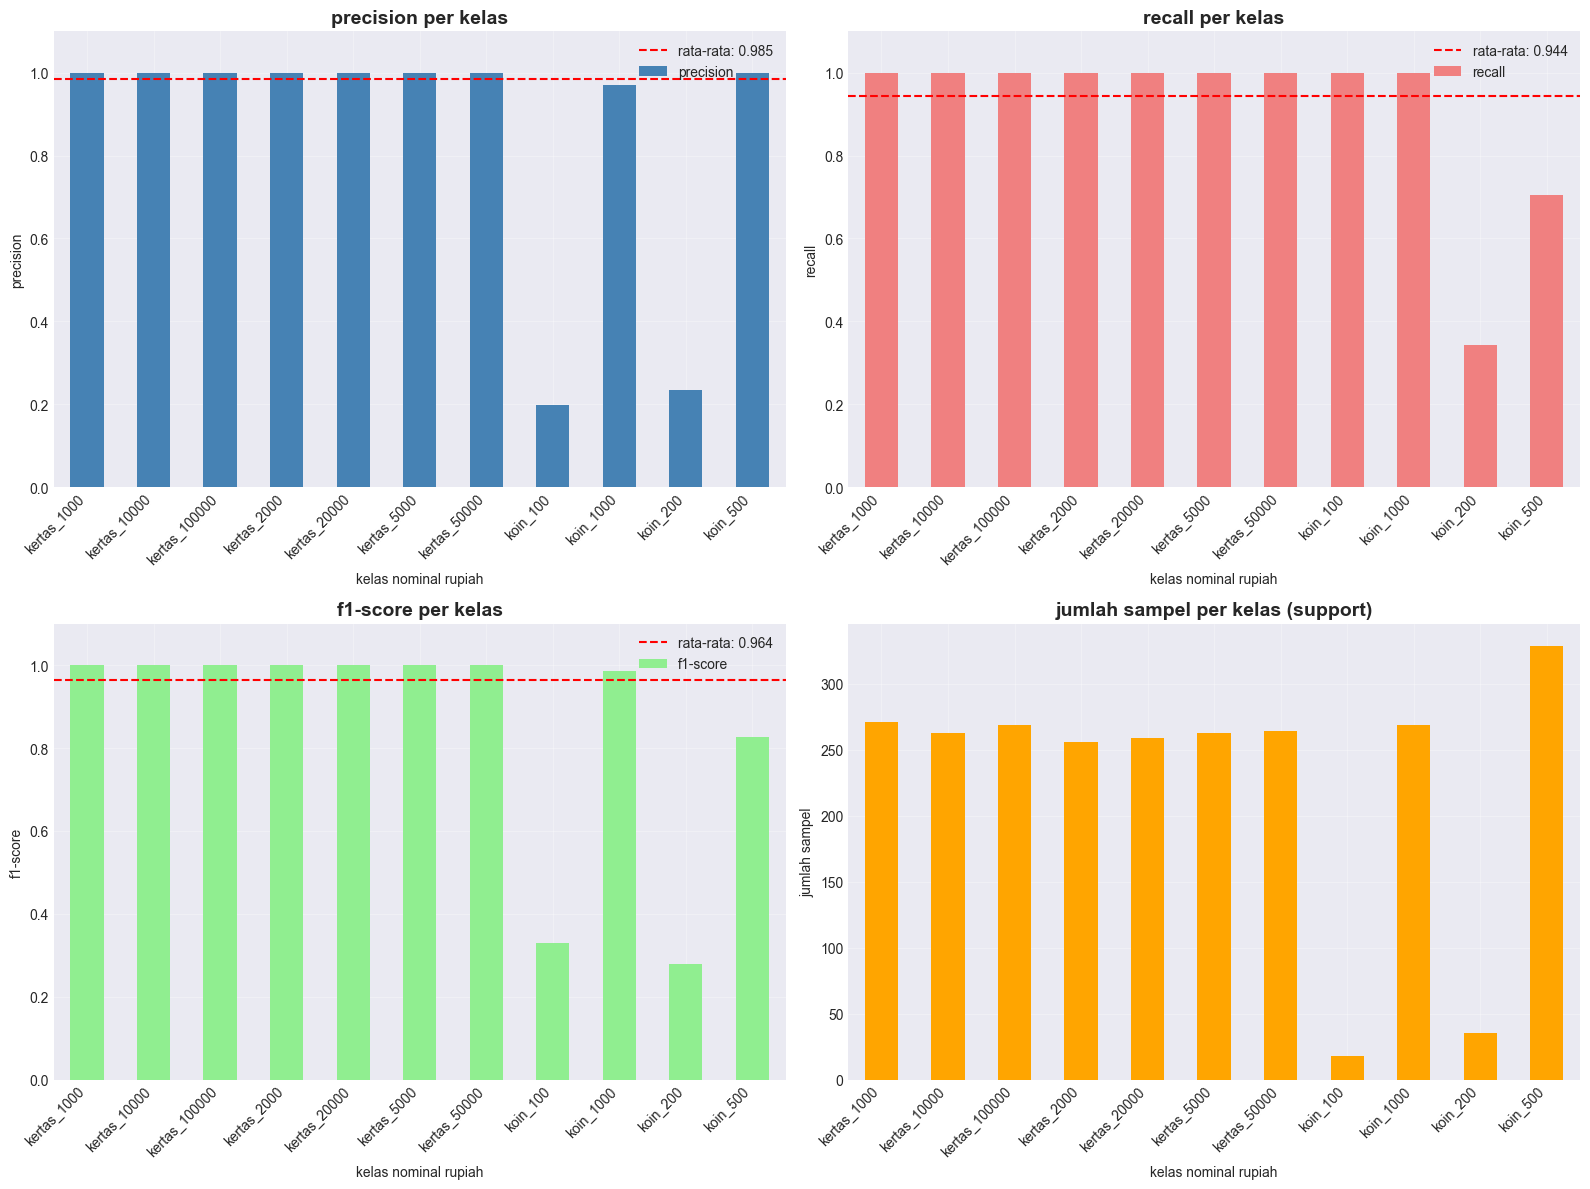

In [45]:
# visualisasi per-class accuracy
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(len(class_names))
)

# buat dataframe untuk visualisasi
metrics_df = pd.DataFrame({
    'class': class_names,
    'precision': precision,
    'recall': recall,
    'f1-score': f1,
    'support': support
})

# visualisasi metrik per kelas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# plot 1: precision per kelas
ax1 = axes[0, 0]
metrics_df.plot(x='class', y='precision', kind='bar', ax=ax1, color='steelblue', legend=False)
ax1.set_title('precision per kelas', fontsize=14, fontweight='bold')
ax1.set_xlabel('kelas nominal rupiah')
ax1.set_ylabel('precision')
ax1.set_ylim([0, 1.1])
ax1.axhline(y=test_precision, color='r', linestyle='--', label=f'rata-rata: {test_precision:.3f}')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# plot 2: recall per kelas
ax2 = axes[0, 1]
metrics_df.plot(x='class', y='recall', kind='bar', ax=ax2, color='lightcoral', legend=False)
ax2.set_title('recall per kelas', fontsize=14, fontweight='bold')
ax2.set_xlabel('kelas nominal rupiah')
ax2.set_ylabel('recall')
ax2.set_ylim([0, 1.1])
ax2.axhline(y=test_recall, color='r', linestyle='--', label=f'rata-rata: {test_recall:.3f}')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# plot 3: f1-score per kelas
ax3 = axes[1, 0]
metrics_df.plot(x='class', y='f1-score', kind='bar', ax=ax3, color='lightgreen', legend=False)
ax3.set_title('f1-score per kelas', fontsize=14, fontweight='bold')
ax3.set_xlabel('kelas nominal rupiah')
ax3.set_ylabel('f1-score')
ax3.set_ylim([0, 1.1])
ax3.axhline(y=test_f1, color='r', linestyle='--', label=f'rata-rata: {test_f1:.3f}')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# plot 4: support per kelas
ax4 = axes[1, 1]
metrics_df.plot(x='class', y='support', kind='bar', ax=ax4, color='orange', legend=False)
ax4.set_title('jumlah sampel per kelas (support)', fontsize=14, fontweight='bold')
ax4.set_xlabel('kelas nominal rupiah')
ax4.set_ylabel('jumlah sampel')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [46]:
# analisis kesalahan prediksi
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"\njumlah kesalahan klasifikasi: {len(misclassified_indices)}")
print(f"persentase kesalahan: {len(misclassified_indices)/len(y_true)*100:.2f}%")

# tampilkan beberapa contoh kesalahan klasifikasi
if len(misclassified_indices) > 0:
    print("\ncontoh kesalahan klasifikasi:")
    
    sample_errors = np.random.choice(misclassified_indices, min(10, len(misclassified_indices)), replace=False)
    
    for idx in sample_errors:
        true_class = class_names[y_true[idx]]
        pred_class = class_names[y_pred[idx]]
        confidence = y_pred_proba[idx][y_pred[idx]] * 100
        print(f"true: {true_class:15} | predicted: {pred_class:15} | confidence: {confidence:.2f}%")


jumlah kesalahan klasifikasi: 120
persentase kesalahan: 4.81%

contoh kesalahan klasifikasi:
true: koin_500        | predicted: koin_100        | confidence: 58.46%
true: koin_500        | predicted: koin_1000       | confidence: 71.21%
true: koin_500        | predicted: koin_100        | confidence: 51.12%
true: koin_500        | predicted: koin_200        | confidence: 41.55%
true: koin_500        | predicted: koin_200        | confidence: 56.39%
true: koin_500        | predicted: koin_200        | confidence: 45.74%
true: koin_500        | predicted: koin_100        | confidence: 50.55%
true: koin_500        | predicted: koin_100        | confidence: 39.64%
true: koin_500        | predicted: koin_100        | confidence: 42.68%
true: koin_500        | predicted: koin_200        | confidence: 43.86%


## 7. Simpan Model

Model yang telah dilatih akan disimpan dalam berbagai format untuk memudahkan deployment dan penggunaan di berbagai platform. Format yang tersedia termasuk keras native format, h5 untuk kompatibilitas backward, dan savedmodel untuk tensorflow serving.

In [49]:
# simpan model dalam berbagai format
model.save('../checkpoints/rupiah_classification_final.keras')
print("model berhasil disimpan dalam format keras")

model.save('../checkpoints/rupiah_classification_final.h5')
print("model berhasil disimpan dalam format h5")

model berhasil disimpan dalam format keras
model berhasil disimpan dalam format h5
model berhasil disimpan dalam format h5


In [50]:
# simpan metadata model untuk referensi
import json
from datetime import datetime

metadata = {
    'model_name': 'Rupiah Classification CNN',
    'version': '1.0',
    'created_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'architecture': 'Custom CNN',
    'input_shape': list(IMG_SIZE) + [3],
    'num_classes': len(class_names),
    'class_names': class_names,
    'total_parameters': int(total_params),
    'trainable_parameters': int(trainable_params),
    'training': {
        'epochs_trained': len(history.history['loss']),
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'loss_function': 'categorical_crossentropy'
    },
    'performance': {
        'train_accuracy': float(final_train_acc),
        'val_accuracy': float(final_val_acc),
        'test_accuracy': float(test_accuracy),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1_score': float(test_f1)
    },
    'dataset': {
        'train_samples': int(train_generator.samples),
        'valid_samples': int(valid_generator.samples),
        'test_samples': int(test_generator.samples),
        'total_samples': int(train_generator.samples + valid_generator.samples + test_generator.samples)
    }
}

# tampilkan metadata
print("\nmetadata model:")
print(json.dumps(metadata, indent=2))


metadata model:
{
  "model_name": "Rupiah Classification CNN",
  "version": "1.0",
  "created_date": "2025-11-11 08:19:35",
  "architecture": "Custom CNN",
  "input_shape": [
    224,
    224,
    3
  ],
  "num_classes": 11,
  "class_names": [
    "kertas_1000",
    "kertas_10000",
    "kertas_100000",
    "kertas_2000",
    "kertas_20000",
    "kertas_5000",
    "kertas_50000",
    "koin_100",
    "koin_1000",
    "koin_200",
    "koin_500"
  ],
  "total_parameters": 5122091,
  "trainable_parameters": 5115563,
  "training": {
    "epochs_trained": 30,
    "batch_size": 32,
    "learning_rate": 0.001,
    "optimizer": "Adam",
    "loss_function": "categorical_crossentropy"
  },
  "performance": {
    "train_accuracy": 0.90625,
    "val_accuracy": 0.9349662065505981,
    "test_accuracy": 0.9519230723381042,
    "test_precision": 0.9845446944236755,
    "test_recall": 0.9443109035491943,
    "test_f1_score": 0.9640081828342894
  },
  "dataset": {
    "train_samples": 3529,
    "valid_sa

## 8. Testing Prediksi pada Gambar Baru

Tahap akhir adalah menguji model pada gambar-gambar baru untuk memverifikasi kemampuan prediksi dalam kondisi real-world. Fungsi prediksi yang dibuat dapat dengan mudah diintegrasikan ke dalam aplikasi produksi.

In [51]:
# fungsi untuk prediksi gambar tunggal
def predict_rupiah(image_path, model, class_names):
    """
    melakukan prediksi pada gambar tunggal
    
    args:
        image_path: path ke file gambar
        model: model yang telah dilatih
        class_names: list nama kelas
    
    returns:
        tuple: (predicted_class, confidence, all_probabilities)
    """
    # load dan preprocess gambar
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # prediksi
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx] * 100
    
    return predicted_class, confidence, predictions[0]

print("fungsi predict_rupiah berhasil didefinisikan")

fungsi predict_rupiah berhasil didefinisikan



testing prediksi pada sampel gambar random dari test set...


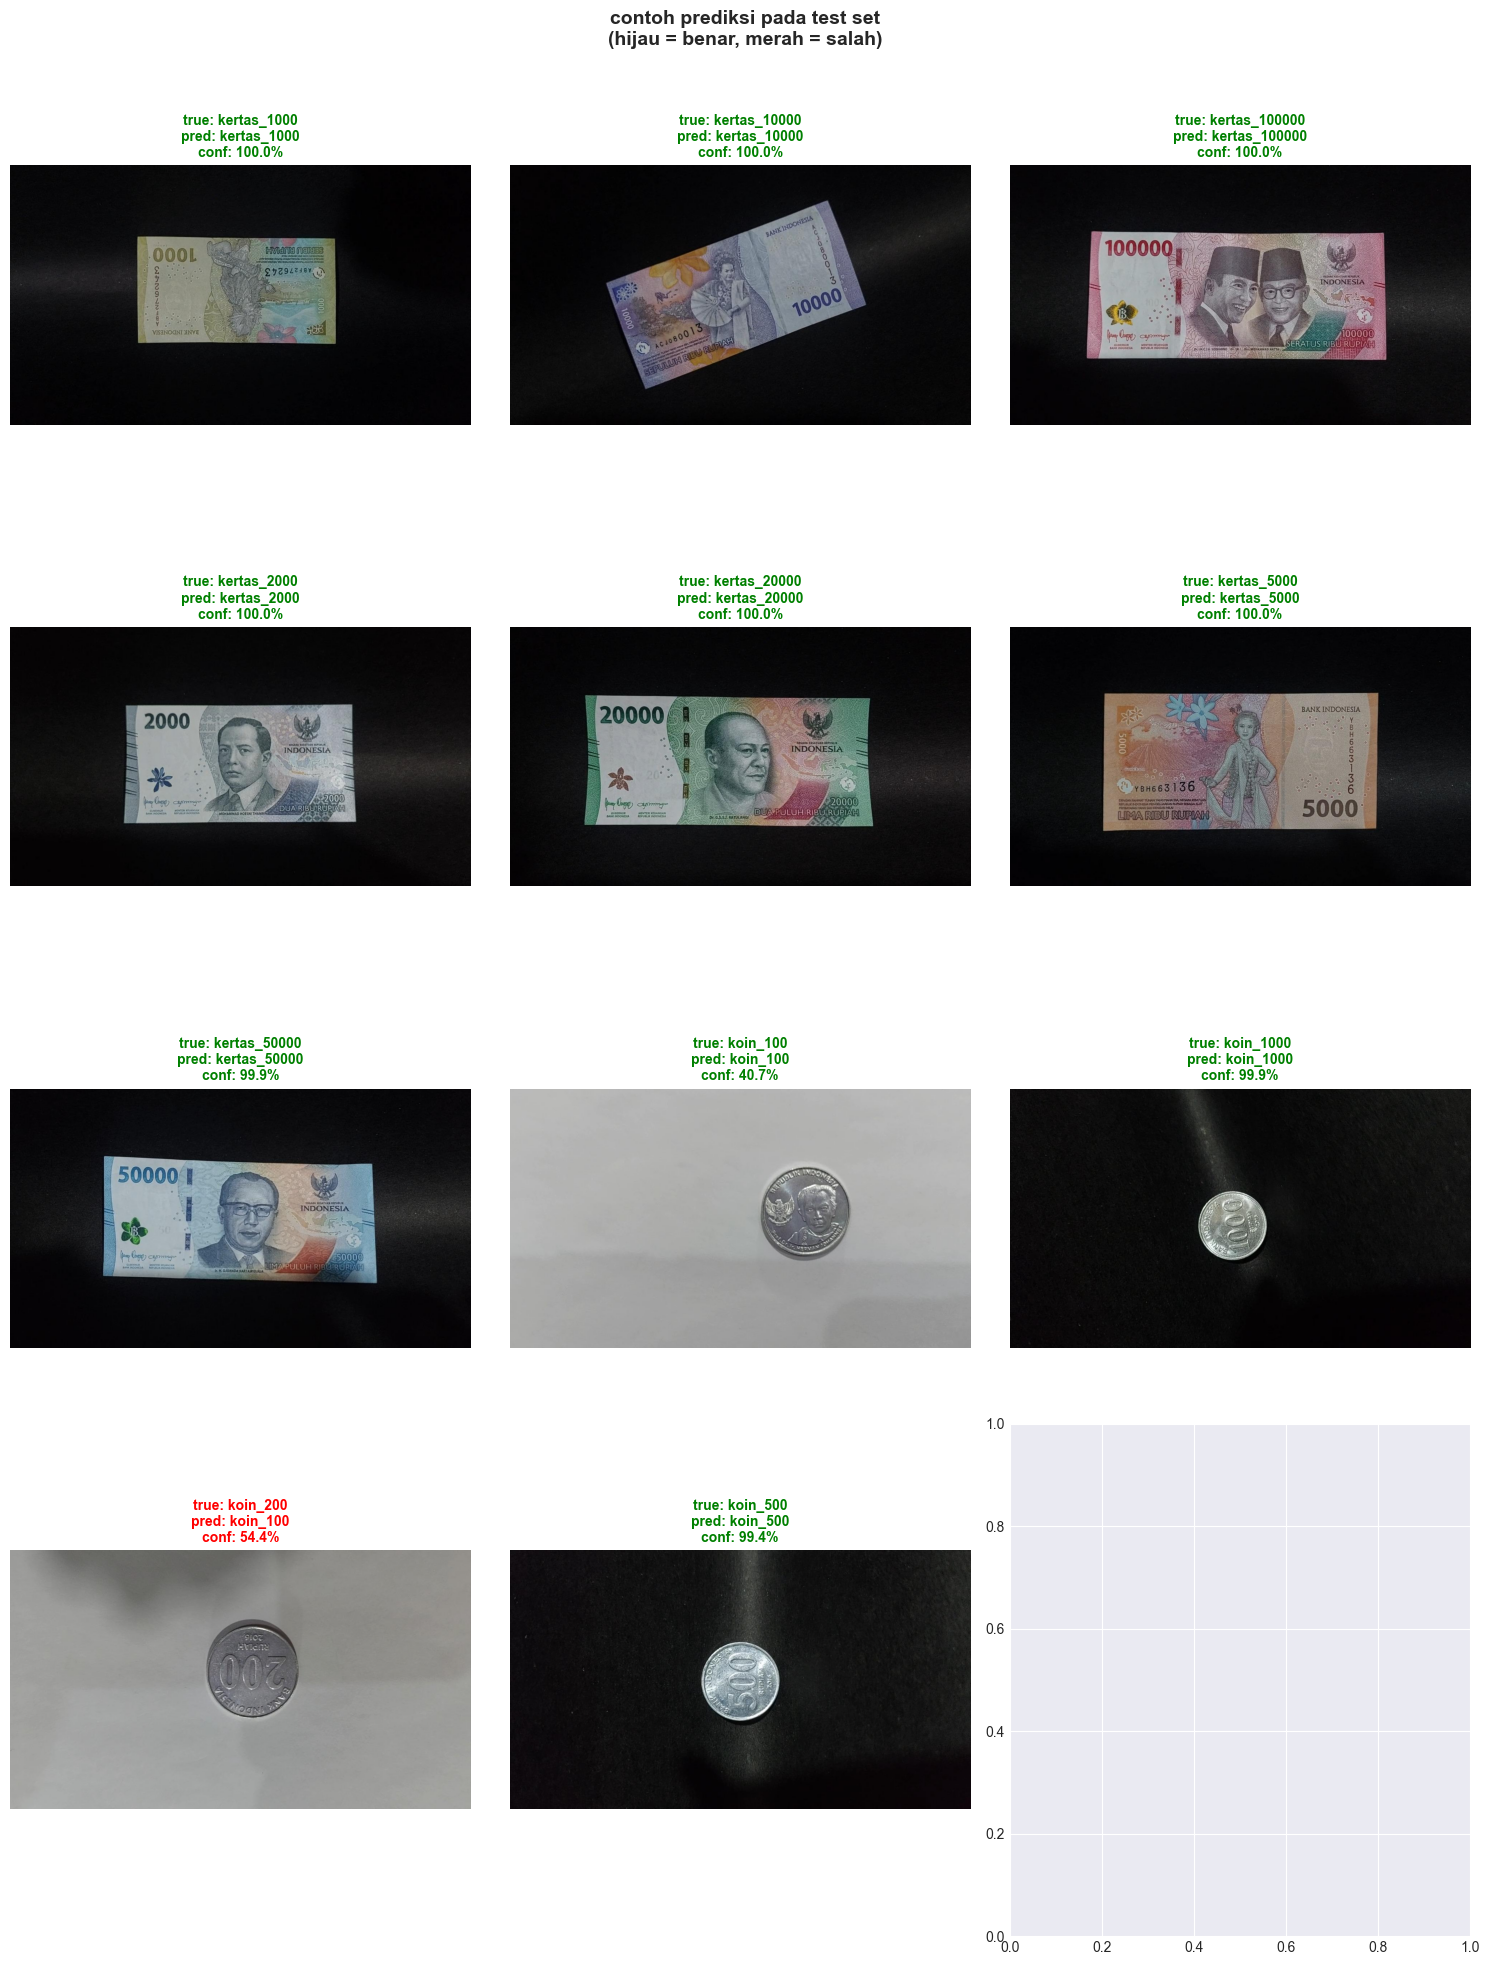

In [52]:
# testing prediksi pada sampel gambar dari test set
print("\ntesting prediksi pada sampel gambar random dari test set...")

# ambil sampel gambar random dari setiap kelas
sample_images_paths = []
for class_name in class_names:
    class_path = test_dir / class_name
    images = list(class_path.glob('*'))
    if images:
        sample_images_paths.append(np.random.choice(images))

# visualisasi prediksi
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.ravel()

for idx, img_path in enumerate(sample_images_paths[:12]):
    # prediksi
    predicted_class, confidence, probabilities = predict_rupiah(img_path, model, class_names)
    
    # true label dari path
    true_class = img_path.parent.name
    
    # load gambar untuk visualisasi
    img = Image.open(img_path)
    
    # plot
    ax = axes[idx]
    ax.imshow(img)
    ax.axis('off')
    
    # warna title berdasarkan prediksi benar/salah
    color = 'green' if predicted_class == true_class else 'red'
    
    title = f'true: {true_class}\npred: {predicted_class}\nconf: {confidence:.1f}%'
    ax.set_title(title, fontsize=10, fontweight='bold', color=color)

plt.suptitle('contoh prediksi pada test set\n(hijau = benar, merah = salah)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Kesimpulan & Ringkasan

Ringkasan lengkap dari seluruh pipeline klasifikasi uang rupiah, mencakup analisis dataset, desain arsitektur, hasil evaluasi, serta rekomendasi untuk pengembangan lebih lanjut. Bagian ini memberikan gambaran menyeluruh tentang kualitas dan keterbatasan model yang telah dibangun.

In [54]:
# ringkasan lengkap proyek
print("\nRINGKASAN PROYEK KLASIFIKASI UANG RUPIAH DENGAN CNN\n")

print("Analisis Dataset:")
print(f"  total kelas: {len(class_names)}")
print(f"  total gambar: {df_counts['total'].sum()}")
print(f"    - training: {df_counts['train'].sum()} ({df_counts['train'].sum()/df_counts['total'].sum()*100:.1f}%)")
print(f"    - validation: {df_counts['valid'].sum()} ({df_counts['valid'].sum()/df_counts['total'].sum()*100:.1f}%)")
print(f"    - testing: {df_counts['test'].sum()} ({df_counts['test'].sum()/df_counts['total'].sum()*100:.1f}%)")

print(f"\n  distribusi data training:")
print(f"    - rata-rata per kelas: {train_mean:.0f} gambar")
print(f"    - std deviasi: {train_std:.0f}")
print(f"    - range: {df_counts['train'].min()} - {df_counts['train'].max()}")

print(f"\n  kelas dengan data terbatas:")
for idx, row in imbalanced_classes.iterrows():
    print(f"    - {idx}: {row['train']} gambar")

print("\nArsitektur Model:")
print("  tipe: custom convolutional neural network")
print("  jumlah convolutional blocks: 5")
print("  fully connected layers: 2")
print(f"  total parameters: {total_params:,}")
print(f"    - trainable: {int(trainable_params):,}")
print(f"    - non-trainable: {int(non_trainable_params):,}")
print(f"  input shape: {IMG_SIZE[0]}x{IMG_SIZE[1]}x3")
print(f"  output classes: {len(class_names)}")

print("\nKonfigurasi Training:")
print(f"  optimizer: Adam (lr={LEARNING_RATE})")
print(f"  loss function: categorical crossentropy")
print(f"  batch size: {BATCH_SIZE}")
print(f"  epochs trained: {len(history.history['loss'])}")
print("  callbacks: model checkpoint, early stopping, reduce lr, tensorboard")
print("  data augmentation: rotation, shift, shear, zoom, flip, brightness")
print("  regularization: dropout, batch normalization, class weights")

print("\nHasil Evaluasi:")
print(f"  training accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"  validation accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"  test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  test precision: {test_precision:.4f} ({test_precision*100:.2f}%)")
print(f"  test recall: {test_recall:.4f} ({test_recall*100:.2f}%)")
print(f"  test f1-score: {test_f1:.4f} ({test_f1*100:.2f}%)")
print(f"  accuracy gap (train-val): {acc_gap:.4f}")

if acc_gap < 0.05:
    print("  status: model well-fitted")
elif acc_gap < 0.10:
    print("  status: slight overfitting")
else:
    print("  status: overfitting detected")


RINGKASAN PROYEK KLASIFIKASI UANG RUPIAH DENGAN CNN

Analisis Dataset:
  total kelas: 11
  total gambar: 9605
    - training: 3529 (36.7%)
    - validation: 3558 (37.0%)
    - testing: 2518 (26.2%)

  distribusi data training:
    - rata-rata per kelas: 321 gambar
    - std deviasi: 140
    - range: 44 - 516

  kelas dengan data terbatas:
    - koin_100: 44.0 gambar
    - koin_200: 66.0 gambar

Arsitektur Model:
  tipe: custom convolutional neural network
  jumlah convolutional blocks: 5
  fully connected layers: 2
  total parameters: 5,122,091
    - trainable: 5,115,563
    - non-trainable: 6,528
  input shape: 224x224x3
  output classes: 11

Konfigurasi Training:
  optimizer: Adam (lr=0.001)
  loss function: categorical crossentropy
  batch size: 32
  epochs trained: 30
  callbacks: model checkpoint, early stopping, reduce lr, tensorboard
  data augmentation: rotation, shift, shear, zoom, flip, brightness
  regularization: dropout, batch normalization, class weights

Hasil Evaluasi: